In [1]:
import json
import gzip
import numpy as np
import pandas as pd
from pathlib import Path
from distutils.log import warn
from tqdm.notebook import tqdm

from pymatgen.core import Composition, Structure
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry

tqdm.pandas()

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import nfp
from nfp import custom_objects
from nfp.layers import RBFExpansion

2025-06-11 11:36:38.652632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-11 11:36:38.739883: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/jlaw/.conda-envs/crystals/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of l

In [3]:
from ubem_training_pretrained_model.preprocess import preprocessor

In [4]:
# since package versions may be important
print(f"{pd.__version__ = }")
print(f"{np.__version__ = }")
print(f"{tf.__version__ = }")
print(f"{nfp.__version__ = }")

pd.__version__ = '1.5.3'
np.__version__ = '1.26.4'
tf.__version__ = '2.10.0'
nfp.__version__ = '0.3.12'


In [5]:
# Not sure which variable pymatgen uses for its version,
# so print it with pip
!pip show pymatgen

Name: pymatgen
Version: 2024.2.8
Summary: Python Materials Genomics is a robust materials analysis code that defines core object representations for structures and molecules with support for many electronic structure codes. It is currently the core analysis code powering the Materials Project (https://materialsproject.org).
Home-page: https://pymatgen.org
Author: Pymatgen Development Team
Author-email: ongsp@ucsd.edu
License: MIT
Location: /home/jlaw/.conda-envs/crystals/lib/python3.10/site-packages
Requires: joblib, matplotlib, monty, networkx, numpy, palettable, pandas, plotly, pybtex, requests, ruamel.yaml, scipy, spglib, sympy, tabulate, tqdm, uncertainties
Required-by: matminer


## Predict the total energy
- This model has been trained with the ICSD and volume-relaxed datasets
- This means it will predict the total energy of a structure in its given state
  - if the structure is unrelaxed, the energy predicted will be an upper-bound for the energy after relaxation

In [ ]:
# first need to download the model using git-lfs 
# then, unzip
!gunzip ubem_training_pretrained_model/best_model.hdf5.gz

In [7]:
# Load the tensorflow model for predicting the total energy of a given structure
energy_model_file = Path("ubem_training_pretrained_model/best_model.hdf5")
print(f"loading {energy_model_file}")
energy_model = tf.keras.models.load_model(energy_model_file,
                                          custom_objects={**custom_objects,
                                                          **{'RBFExpansion': RBFExpansion}})

loading ubem_training_pretrained_model/best_model.hdf5


Here's an example of how to predict the energy for a structure

In [8]:
# Here we define some convenience functions for preprocessing structures and generating predictions
def get_structures(structures_file):
    """ Load and preprocess structures from a pymatgen json.gz file
    """
    print(f"Reading {structures_file}")
    with gzip.open(structures_file, "rb") as f:
        for entry in tqdm(json.loads(f.read().decode())):
            key = entry["id"]
            structure_dict = entry["structure"]
            structure = Structure.from_dict(structure_dict)
            yield {"id": key, "structure": structure}


def preprocess_structure(structure):
    inputs = preprocessor(structure)
    # scale structures to a minimum of 1A interatomic distance
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        warn(f"Error with {row.id}")
        return None

    scale_factor = 1.0 / inputs["distance"].min()
    inputs["distance"] *= scale_factor
    return inputs


def build_dataset(structures, batch_size=8):
    dataset = tf.data.Dataset.from_generator(
        lambda: (preprocess_structure(s) for s in structures),
        output_signature=(preprocessor.output_signature),
        ).padded_batch(
            batch_size=batch_size,
            padding_values=(preprocessor.padding_values),
        )
    return dataset


def predict_energy(energy_model, structures):
    dataset = build_dataset(structures)
    predicted_energy = energy_model.predict(dataset)
    return predicted_energy.flatten()

In [9]:
# Load an example structure from file. 
structure_file = "ubem_training_pretrained_model/inputs/POSCAR_example"
structure = Structure.from_file(structure_file)
structure

Structure Summary
Lattice
    abc : 6.31324215781406 4.129266345748309 6.313262245757987
 angles : 89.99981298298509 115.93116321347914 90.00022269721498
 volume : 148.01081824725688
      A : 6.31320261273 -1.29824151174e-05 -0.0223453272811
      B : -7.5462453492e-06 4.12926634574 3.4182060174e-06
      C : -2.74061976372 1.08903819355e-05 5.6873793169
    pbc : True True True
PeriodicSite: Li (3.157, 3.875, -0.01117) [0.5, 0.9384, 2.76e-08]
PeriodicSite: Sc (3.205, 3.879, 3.917) [0.8081, 0.9394, 0.6919]
PeriodicSite: Sc (0.3672, 3.879, 1.748) [0.1919, 0.9394, 0.3081]
PeriodicSite: F (1.041, 3.878, 3.808) [0.4563, 0.9392, 0.6713]
PeriodicSite: F (2.532, 3.878, 1.857) [0.5437, 0.9392, 0.3287]
PeriodicSite: F (5.112, 3.878, 0.2302) [0.8287, 0.9392, 0.04373]
PeriodicSite: F (-1.54, 3.878, 5.435) [0.1713, 0.9392, 0.9563]
PeriodicSite: F (3.154, 1.814, 3.949) [0.8024, 0.4394, 0.6976]
PeriodicSite: F (0.4188, 1.814, 1.716) [0.1976, 0.4394, 0.3024]
PeriodicSite: F (-1.37, 3.881, 2.844) [2.

In [10]:
predicted_energies = predict_energy(energy_model, [structure])
predicted_energies

      1/Unknown - 1s 1s/step

2025-06-11 11:38:14.502288: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 2s 2s/step


array([-0.27297476], dtype=float32)

### Make predictions for the entire zintl space
Load the decorated structures and run them through the model

In [11]:
structures = list(get_structures("decorations_prototypes.json.gz"))
print(len(structures))

Reading decorations_prototypes.json.gz


  0%|          | 0/90856 [00:00<?, ?it/s]

90856


In [12]:
structures = {row["id"]: row["structure"] for row in structures}

In [13]:
# just show the first 10 as an example
predicted_energies = predict_energy(energy_model, list(structures.values())[:10])
predicted_energies

2/2 [==============================] - 0s 63ms/step


array([-4.302996 , -4.0243497, -5.312324 , -4.000423 , -4.379902 ,
       -4.5538793, -4.0985417, -3.9308417, -4.218911 , -4.132236 ],
      dtype=float32)

In [14]:
df = pd.DataFrame([list(structures.keys())[:10], predicted_energies]).T
df.columns = ["structure", "predicted_energy"]
df

,structure,predicted_energy
0,POSCAR_a2e1_205_P2Si1_icsd_024333_P_Pb,-4.302996
1,POSCAR_a2e1_205_P2Si1_icsd_024333_Sb_Sn,-4.02435
2,POSCAR_a2e1_205_P2Si1_icsd_024333_P_Si,-5.312324
3,POSCAR_a2e1_205_P2Si1_icsd_024333_Bi_Ge,-4.000423
4,POSCAR_a2e1_205_P2Si1_icsd_024333_As_Sn,-4.379902
5,POSCAR_a2e1_205_P2Si1_icsd_024333_As_Ge,-4.553879
6,POSCAR_a2e1_205_P2Si1_icsd_024333_Bi_Si,-4.098542
7,POSCAR_a2e1_205_P2Si1_icsd_024333_Bi_Sn,-3.930842
8,POSCAR_a2e1_205_P2Si1_icsd_024333_Sb_Si,-4.218911
9,POSCAR_a2e1_205_P2Si1_icsd_024333_As_Pb,-4.132236


In [15]:
# I ran the predictions separately. Load them here
# note that some structures with Yb or Eu were removed
pred_file = "ubem_prediction_validation/ubem_prediction.csv"
df = pd.read_csv(pred_file, index_col=0)
print(len(df))
df.head(2)

72696


,composition,ubem_vol_only_energy,ubem_decomp_energy
id,,,
POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al,Al1As1,-4.516,-0.406
POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As_Ba_Al,Al1As11Ba14,-4.153,0.051


<Axes: ylabel='Frequency'>

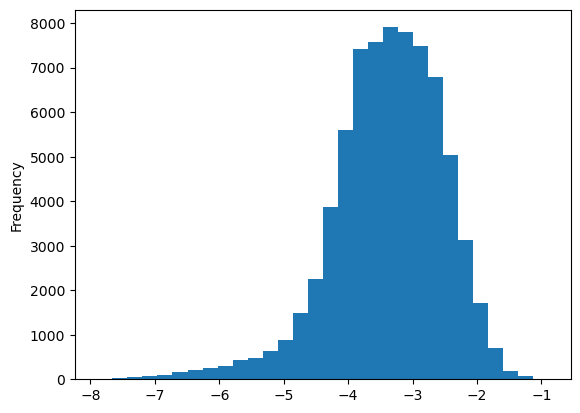

In [16]:
df.ubem_vol_only_energy.plot.hist(bins=30)

## Decomposition Energy
- Build the convex hull and compute the predicted decomposition energy for this structure
- We can also compute all of the "sub-rewards" we're interested in
- To compute the self-consistent decomposition energy, we would need all the DFT-relaxed energies we have, as well as the lowest predicted energy for each relevant composition

In [17]:
from ubem_training_pretrained_model.ehull import setup_competing_phases, convex_hull_stability

In [18]:
# first load the competing phases from NREL MatDB
competing_phases_file = "ubem_training_pretrained_model/inputs/competing_phases.csv"
competing_phases = setup_competing_phases(competing_phases_file)

Reading ubem_training_pretrained_model/inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4
	12682 entries


In [19]:
df_comp_phases = pd.read_csv("ubem_training_pretrained_model/inputs/competing_phases.csv", index_col=0)
print(len(df_comp_phases))
df_comp_phases.head(2)

12682


,icsdnum,energyperatom,reduced_composition
sortedformula,,,
Ag10Br3Te4,173116.0,-1.718985,Ag10Br3Te4
Ag11K1O16V4,391344.0,-4.797702,Ag11K1O16V4


### Cacluate the 'self-consistent' decomposition energy by including the lowest predicted energy for each composition

In [20]:
df2 = df.reset_index()

In [21]:
df2.head(2)

,id,composition,ubem_vol_only_energy,ubem_decomp_energy
0,POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al,Al1As1,-4.516,-0.406
1,POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As...,Al1As11Ba14,-4.153,0.051


<Axes: ylabel='Frequency'>

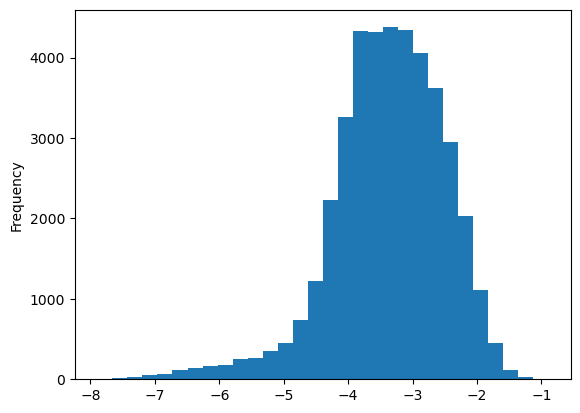

In [22]:
comps_min_energy = df2[["id", "composition", "ubem_vol_only_energy"]].groupby("composition").min()
comps_min_energy.ubem_vol_only_energy.plot.hist(bins=30)

In [23]:
comps_min_energy = comps_min_energy.reset_index()
comps_min_energy.head(2)

,composition,id,ubem_vol_only_energy
0,Al1As1,POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al,-4.516
1,Al1As11Ba14,POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As...,-4.153


In [24]:
comp_overlap_icsd = set(comps_min_energy.composition.values) & set(df_comp_phases.reduced_composition.values)
print(len(comp_overlap_icsd))

541


In [25]:
comps_min_energy_unique = comps_min_energy[~comps_min_energy.composition.isin(comp_overlap_icsd)]
print(len(comps_min_energy), len(comps_min_energy_unique))

41284 40743


In [27]:
energy_col = "ubem_vol_only_energy"
comp_col = "composition"
comps_min_energy_unique['energy'] = (
    comps_min_energy_unique[energy_col] *
    comps_min_energy_unique[comp_col].apply(lambda x: Composition(x).num_atoms)
)
# convert the dataframe to a list of PDEntries used to create the convex hull
pd_entries = comps_min_energy_unique.apply(
    lambda row: PDEntry(Composition(row[comp_col]),
                        row.energy),
    axis=1
)
print(f"\t{len(pd_entries)} entries")

/tmp/ipykernel_676114/1599373682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comps_min_energy_unique['energy'] = (


	40743 entries


In [28]:
len(competing_phases)

12742

In [29]:
competing_phases_wpred = list(competing_phases) + list(pd_entries)
print(len(competing_phases_wpred))

53485


Can run here, or skip the next three cells to use the pre-computed decomposition energies

In [ ]:
# compute the decomposition energies of the structures
decomp_energies = {}
for s_id, energyperatom in tqdm(df2[["structure", "ubem_vol_only_energy"]].values):
    structure = structures[s_id]
    try:
        decomp_energy = convex_hull_stability(structure.composition,
                                              energyperatom,
                                              competing_phases_wpred,
                                             )
        decomp_energies[s_id] = decomp_energy
    except ValueError as e:
        print(f"ValueError for {s_id}: {e}")
        decomp_energies[s_id] = np.nan
    # reward, info = rewarder.compute_reward(comp, energyperatom)
    # decomp_energies[s_id] = info['decomp_energy']

In [77]:
df_sc = comps_min_energy.copy()
df_sc.drop(columns="energy", inplace=True)
df_sc.head(2)

,composition,decomp_energy,predicted_energy,structure
0,Al1As1,-0.406064,-4.516064,POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al
1,Al1As11Ba14,-0.040416,-4.152862,POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As...


In [78]:
df_sc = df_sc.set_index('structure')
df_sc['ubem_decomp_energy'] = decomp_energies
df_sc.head(2)

,composition,decomp_energy,predicted_energy
structure,,,
POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al,Al1As1,-0.406064,-4.516064
POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As_Ba_Al,Al1As11Ba14,0.050697,-4.152862


In [14]:
df2.head(2)

,id,composition,ubem_vol_only_energy,ubem_decomp_energy
0,POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al,Al1As1,-4.516,-0.406
1,POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As...,Al1As11Ba14,-4.153,0.051


In [30]:
# the decomposition energies were calculated separately
df_sc = df2[["id", "composition", "ubem_decomp_energy"]].groupby("composition").min().reset_index()
print(len(df_sc))
df_sc.head(2)

41284


,composition,id,ubem_decomp_energy
0,Al1As1,POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al,-0.406
1,Al1As11Ba14,POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As...,0.051


In [31]:
df_sc2 = df_sc.copy()

In [32]:
# restrict the compositions to those not in ICSD
df_sc = df_sc[~df_sc.composition.isin(comp_overlap_icsd)]

In [33]:
df_sc[df_sc.ubem_decomp_energy < 0.01]

,composition,id,ubem_decomp_energy
3,Al1As11Ca14,POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As...,-0.026
39,Al1As2Cs2Li1,POSCAR_a2b1b2d1_64_As2In1K2Li1_icsd_402147_Cs_...,-0.015
40,Al1As2Cs2Na1,POSCAR_a2b1b2d1_64_As2In1K2Li1_icsd_402147_Cs_...,-0.046
42,Al1As2Cs3,POSCAR_a2b1b2d1_64_As2In1K2Li1_icsd_402147_Cs_...,-0.026
50,Al1As2K2Li1,POSCAR_a2b1b2d1_64_As2In1K2Li1_icsd_402147_K_L...,-0.027
...,...,...,...
41066,Sb3Sr4,POSCAR_a3c2c2_12_Eu2P3Zn2_icsd_426082_Sr_Sb_Sr,-0.012
41116,Sb4Sr5,POSCAR_a4c2c3_12_As4Ba3Zn2_icsd_424760_Sb_Sr_Sr,-0.015
41207,Sb7Zn8,POSCAR_a7c8_31_Sb7Zn8_icsd_238947_Sb_Zn,0.007
41235,Sb8Sr11Zn14,POSCAR_a14c11c8_12_Ba11Bi14Cd8_icsd_240338_Sb_...,-0.109


In [ ]:
df_sc.to_csv("sc_decomp_energies.csv")